A partir del analisis de partidos de padel, teniendo en cuenta a los equipos (no a los jugadores individuales), se realizará un modelo de machine learning supervisado con el objetivo de predecir cuál pareja gana el set (variable dependiente) a partir de las variables independientes (puntos por game, remates, errores no forzados, etc). También, se evaluará cuáles variables independientes aumentan la precision del modelo y cuales se podrian descartar

In [3]:
import numpy as np
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier

In [4]:
df = pd.read_excel("_ml1_eqxset.xlsx")

In [5]:
#quitar outlier de sd en bruselas 3er set
df.drop(49, axis=0, inplace=True)

#cambiar index
df.set_index('nombre',inplace=True)

In [6]:
#todas las columnas
all_cols = ['nf', 'w', 'sm', 'ns', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed','games jug', "set"]

#columnas para ML
res_col = [ "pto_tot", "tot_snf", "nf","games jug"]

Del dataframe nos quedamos con los sets en donde no hubo tiebreak, en el cual hay un ganador y un perdedor. El tiebreak tiene reglas diferentes a la de los otros sets, por lo que lo consideramos empate.

In [7]:
#df con set ganados
df_gano = df[df["gano_set"]=="g"]

#del set ganado, nos quedamos con las columnas para el ML
df_gano = df_gano[res_col]

#normalizamos todas las columnas para obtener valores en un game
df_ganoxgame = round(df_gano.div(df_gano["games jug"], axis=0),3)

#agregamos columna con el resultado g (ganó)
df_ganoxgame["result"] ="g"

df_ganoxgame.head()

,pto_tot,tot_snf,nf,games jug,result
nombre,,,,,
Tap-Coe,2.900,1.900,0.200,1.0,g
Tap-Coe,3.444,2.222,0.556,1.0,g
Tap-Coe,3.200,1.800,0.600,1.0,g
Momo-Sanyo,2.800,1.900,0.900,1.0,g
Tap-Coe,2.800,1.900,0.900,1.0,g


In [8]:
#df con set perdidos
df_perdio = df[df["gano_set"]=="p"]

#del set perdio, nos quedamos con las columnas para el ML
df_perdio = df_perdio[res_col]

#normalizamos todas las columnas para obtener valores en un game
df_perdioxgame = round(df_perdio.div(df_perdio["games jug"], axis=0),3)

#agregamos columna con el resultado p (perdió)
df_perdioxgame["result"] ="p"

df_perdioxgame.head()

,pto_tot,tot_snf,nf,games jug,result
nombre,,,,,
Gal-Leb,2.000,1.800,1.000,1.0,p
Tello-Ruiz,1.889,1.333,1.222,1.0,p
Tello-Ruiz,2.400,1.800,1.400,1.0,p
Paquito-Chingotto,3.200,2.300,0.900,1.0,p
Stupa-Di,3.200,2.300,0.900,1.0,p


Concatenamos los dataframes de los sets perdidos y ganados, y transformamos el ganar en 1, y el perder en 0

In [9]:
#unimos dataframes
all = pd.concat([df_ganoxgame, df_perdioxgame])

#borramos la columna con los games jugados porque no tienen utilidad
all.drop("games jug", axis=1, inplace=True)

#transformamos la variable de categorica a numerica. g es 1, p es 0
all["result"] = np.where(all["result"] == "g",1,0)
print(all.shape)
all.head()

(165, 4)


,pto_tot,tot_snf,nf,result
nombre,,,,
Tap-Coe,2.900,1.900,0.200,1
Tap-Coe,3.444,2.222,0.556,1
Tap-Coe,3.200,1.800,0.600,1
Momo-Sanyo,2.800,1.900,0.900,1
Tap-Coe,2.800,1.900,0.900,1


# ver top 5

In [10]:
all_grup = all.reset_index().groupby("nombre")[["pto_tot", "tot_snf","nf"]].mean()

all_grup.sort_values("pto_tot", ascending=False)

,pto_tot,tot_snf,nf
nombre,,,
Tap-Coe,3.160270,2.217189,0.668351
Stupa-Di,3.152567,2.224767,0.755667
Moyano-Xisco,2.844500,1.905500,0.589250
Paquito-Chingotto,2.790222,1.811889,0.881833
Gal-Leb,2.776364,1.950818,0.991182
Leal-Bel,2.766500,1.908500,0.991500
coki-Sanz,2.613667,1.767333,0.817333
Momo-Sanyo,2.570762,1.763905,0.896333
Augsburguer-JaviRico,2.486000,1.243000,0.819500


In [11]:
all_grup.sort_values("nf")

,pto_tot,tot_snf,nf
nombre,,,
Moyano-Xisco,2.844500,1.905500,0.589250
Tap-Coe,3.160270,2.217189,0.668351
Stupa-Di,3.152567,2.224767,0.755667
Garrido-Sanz,1.777500,1.389000,0.778000
Coki-Cardona,1.696500,0.973000,0.794500
coki-Sanz,2.613667,1.767333,0.817333
Augsburguer-JaviRico,2.486000,1.243000,0.819500
Bela-Yanguas,2.482200,1.801200,0.841200
Paquito-Chingotto,2.790222,1.811889,0.881833


In [12]:
all_grup.sort_values("tot_snf", ascending=False)

,pto_tot,tot_snf,nf
nombre,,,
Stupa-Di,3.152567,2.224767,0.755667
Tap-Coe,3.160270,2.217189,0.668351
Gal-Leb,2.776364,1.950818,0.991182
Leal-Bel,2.766500,1.908500,0.991500
Moyano-Xisco,2.844500,1.905500,0.589250
Paquito-Chingotto,2.790222,1.811889,0.881833
Bela-Yanguas,2.482200,1.801200,0.841200
coki-Sanz,2.613667,1.767333,0.817333
Momo-Sanyo,2.570762,1.763905,0.896333


### Agrupar segun nombres y con medias, para ver como les va a cada pareja en el ML

In [13]:
all_g = all.groupby("nombre")[["pto_tot","tot_snf","nf"]].mean().sort_values("pto_tot", ascending=False)
all_g

,pto_tot,tot_snf,nf
nombre,,,
Tap-Coe,3.160270,2.217189,0.668351
Stupa-Di,3.152567,2.224767,0.755667
Moyano-Xisco,2.844500,1.905500,0.589250
Paquito-Chingotto,2.790222,1.811889,0.881833
Gal-Leb,2.776364,1.950818,0.991182
Leal-Bel,2.766500,1.908500,0.991500
coki-Sanz,2.613667,1.767333,0.817333
Momo-Sanyo,2.570762,1.763905,0.896333
Augsburguer-JaviRico,2.486000,1.243000,0.819500


## Dividir entre train y set
se crea la funcion entrenar y se entrena con el 80%

In [14]:
def entrenar(df_):
    xx = df_[df_.columns[:-1]].values
    yy = df_[df_.columns[-1]].values
    
    return xx, yy
xx, yy = entrenar(all)

x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=45, stratify=yy)


se crea la funcion vecinos para evaluar cantidad de k optima

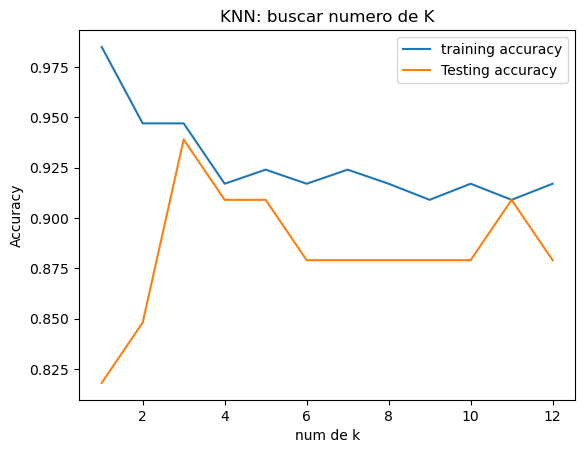

In [15]:
def vecinos():
    neighbors = np.arange(1,13)
    train_accuracies = {}
    test_accuracies = {}
    for neighbor in neighbors:
        model = KNeighborsClassifier(n_neighbors=neighbor)
        model.fit(x_train, y_train)
    
        #computar precision
        train_accuracies[neighbor] = round(model.score(x_train, y_train),3)
        test_accuracies[neighbor] = round(model.score(x_test, y_test),3)
    #print(test_accuracies)
    #print(neighbor,"\n", train_accuracies, "\n", test_accuracies)
    plt.title("KNN: buscar numero de K")
    plt.plot(neighbors, train_accuracies.values(),label= "training accuracy")
    plt.plot(neighbors, test_accuracies.values(), label = "Testing accuracy")
    plt.legend()
    plt.xlabel("num de k")
    plt.ylabel("Accuracy")
    plt.show()
vecinos()

3 es el k con la acurracy mas alta, por lo que se usará k=3 en el modelo de KNeighborsClassifier

In [16]:

from sklearn.metrics import accuracy_score
num_k = 3
#elegir modelo, calibramos al svm y decisiontree que son los que necesitan de calibracion par aprobabilidades

lg = LogisticRegression()
svm_model = SVC(kernel='linear', probability=True) #support vector machine
svm_cal = CalibratedClassifierCV(svm_model)
nb = GaussianNB() #naibes
dt = DecisionTreeClassifier(max_depth=3, random_state=1, criterion ="gini")
dt_cal =  CalibratedClassifierCV(dt)
bag_class= BaggingClassifier(estimator=nb, n_estimators=300, n_jobs=-1)




mejor_modelo = None
mejor_puntaje = 0
dicc_prec = {}
list_model = {"lg":lg, "svm":svm_cal, "nb":nb,"dt":dt_cal, "bagging":bag_class}

for key, modelo in list_model.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    #obtenemos el puntaje
    puntaje = accuracy_score(y_test, y_pred)
    dicc_prec[key] = puntaje
    
    if puntaje > mejor_puntaje:
        mejor_puntaje = puntaje
        mejor_modelo = modelo
        
#tenemos el modelo con el mejor accuracy_Score, que es la variable: mejor_modelo, asi que ahora se entrena
mejor_modelo.fit(x_train, y_train)
y_predict = mejor_modelo.predict(x_test)

print(dicc_prec)

{'lg': 0.9090909090909091, 'svm': 0.9090909090909091, 'nb': 0.8787878787878788, 'dt': 0.8787878787878788, 'bagging': 0.8787878787878788}


In [17]:
print("El modelo con el mayor puntaje es:", mejor_modelo, round(mejor_puntaje,2))

El modelo con el mayor puntaje es: LogisticRegression() 0.91


In [18]:
print(all_g.head())

                    pto_tot   tot_snf        nf
nombre                                         
Tap-Coe            3.160270  2.217189  0.668351
Stupa-Di           3.152567  2.224767  0.755667
Moyano-Xisco       2.844500  1.905500  0.589250
Paquito-Chingotto  2.790222  1.811889  0.881833
Gal-Leb            2.776364  1.950818  0.991182


In [19]:

#probar modelo
#new_data = np.array([3.199742,2.267935,0.624129])
#new_data = np.array([[3.199742,2.267935,0.624129], [3,3,0.2]])
#3.160270  2.217189  0.668351
new_data = np.array([all_g.iloc[0], all_g.iloc[1], all_g.iloc[2], all_g.iloc[3],all_g.iloc[-1]])




y_p3 = mejor_modelo.predict_proba(new_data).round(3)
y_p4 = lg.predict_proba(new_data).round(3)

# Crear el modelo SVM con probability=True
svm_model = SVC(kernel='linear', probability=True)

# Calibrar el modelo para obtener estimaciones de probabilidad calibradas
calibrated_svm = CalibratedClassifierCV(svm_model)
calibrated_svm.fit(x_train, y_train)
# Calcular probabilidades para las clases
probabilities =calibrated_svm.predict_proba(new_data).round(3)

nb_proba = nb.predict_proba(new_data).round(3)
dt_proba = dt_cal.predict_proba(new_data).round(3)

print(f"Mejor modelo: {y_p3}")
print(f"lg: {y_p4}")
print(f"svm: {probabilities}")
print(f"nb modelo: {nb_proba}")
print(f"dt modelo: {dt_proba}")

Mejor modelo: [[0.132 0.868]
 [0.147 0.853]
 [0.398 0.602]
 [0.565 0.435]
 [0.994 0.006]]
lg: [[0.132 0.868]
 [0.147 0.853]
 [0.398 0.602]
 [0.565 0.435]
 [0.994 0.006]]
svm: [[0.165 0.835]
 [0.179 0.821]
 [0.409 0.591]
 [0.55  0.45 ]
 [0.989 0.011]]
nb modelo: [[0.01  0.99 ]
 [0.014 0.986]
 [0.199 0.801]
 [0.657 0.343]
 [1.    0.   ]]
dt modelo: [[0.141 0.859]
 [0.141 0.859]
 [0.437 0.563]
 [0.648 0.352]
 [0.868 0.132]]


In [20]:
vtc.predict_proba(3.132120,2.191760,0.767760.reshape(1,-1))

NameError: name 'vtc' is not defined

In [ ]:
print(classification_report(y_test, y_pred))

Elijo como metrica accuracy porque evalua las etiquetadas correctamente, tanto positivas como negativas. Otra opcion
pudo haber sido f1, porque es la media entre recall y precision

In [ ]:
cf_matrix = confusion_matrix(y_test,y_predict)
print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
ax.set_title("Matrix de confusion con labels\n\n")
ax.set_xlabel("Valores predichos")
ax.set_ylabel("Valores reales")
#ticket labels en orden alfabetico
ax.xaxis.set_ticklabels(["Negativo", "Positivo"])
ax.yaxis.set_ticklabels(["Negativo", "Positivo"])
plt.show()

el modelo tenia 97% de precision, por lo que se observa que solo en una observacion hubo un falso positivo, habian perdido pero lo predijo como que habian ganado el set.

# Random forest y otros

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

dt= DecisionTreeClassifier(max_depth=3, random_state=1, criterion ="gini")

dt.fit(x_train, y_train)

ydt_predict = dt.predict(x_test)

nivel_acc = accuracy_score(y_test, ydt_predict)

#nivel_acc

mse_cv = cross_val_score(dt, x_train, y_train,cv=10, scoring='recall') # 'accuracy', 'precision', 'recall', 'f1', 

mse_cv.mean()

## Votting

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier 

lr = LogisticRegression(random_state =0)
knn = KNN(n_neighbors=3)
dt = DecisionTreeClassifier(random_state=0, max_depth=3)
sup_vc = SVC() 


classifiers = [("Logistic regression", lr),
              ("K nearest neighbors", knn),
               ("classification tree", dt),
              ("Suport vector", sup_vc)]

for clf_name, clf in classifiers:
    clf.fit(x_train, y_train)
    
    y1_pred = clf.predict(x_test)
    
    print(clf_name, round(accuracy_score(y_test, y1_pred),3))
    
    
vtc= VotingClassifier(estimators =classifiers)
vtc.fit(x_train, y_train)

y2_pred = vtc.predict(x_test)

accuracy_score(y_test, y2_pred)

### predecir probabilidades

In [ ]:
vtc.predict_proba(3.132120,2.191760,0.767760.reshape(-1,1))